In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from tqdm import tqdm

from modules import *
from networks import *
from training import *

SIZE = 256

transform = A.Compose([
    A.Resize(height=SIZE, width=SIZE, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(),
    ToTensorV2(),
])
loader = load_dataset('../data/DRISHTI/ROI/TestImages', '../data/DRISHTI/ROI/TestMasks', transform, 1, shuffle=False)

Loaded dataset with 51 samples in 51 batches.


In [2]:
path = r"..\models\polar\rau\dual.pth"
checkpoint = load_checkpoint(path, map_location='cpu')
model = checkpoint['model']
model.eval()

=> Loading checkpoint: ..\models\polar\rau\dual.pth


DualRAUnetPlusPlus(
  (encoder): RauEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): ResidualConv(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (conv2): ResidualConv(
      (conv): Sequential(
        (0): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

Initial shapes: torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
Min: tensor(-2.1179) tensor(0)
Max: tensor(1.6838) tensor(2)
TTA shapes: torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
Numpy shapes: (8, 256, 256, 3) (8, 256, 256)


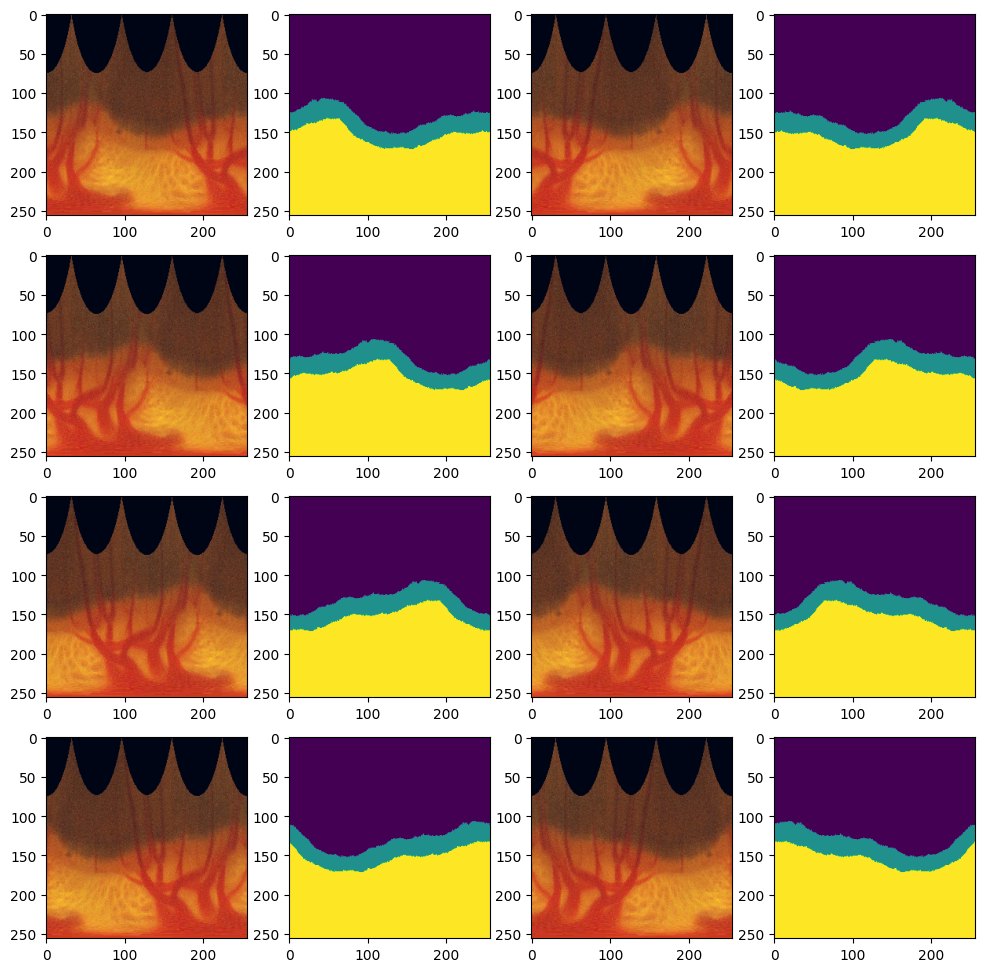

In [3]:
batch_images, batch_masks = next(iter(loader))
batch_images, batch_masks = batch_images.float(), batch_masks.long()

print('Initial shapes:', batch_images.shape, batch_masks.shape)
print('Min:', batch_images.min(), batch_masks.min())
print('Max:', batch_images.max(), batch_masks.max())
tta_images, tta_masks = d4_transform(batch_images, batch_masks, polar=True)
if tta_masks is None:
    tta_masks = torch.zeros(tta_images.shape[0], tta_images.shape[2], tta_images.shape[3], 1)
print('TTA shapes:', tta_images.shape, tta_masks.shape)

images = tta_images.detach().cpu().numpy().transpose(0, 2, 3, 1)
masks = tta_masks.detach().cpu().numpy()
images -= images.min()
images /= images.max()
print('Numpy shapes:', images.shape, masks.shape)

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.flatten()
ax[0].imshow(images[0])
ax[1].imshow(masks[0])
ax[2].imshow(images[1])
ax[3].imshow(masks[1])
ax[4].imshow(images[2])
ax[5].imshow(masks[2])
ax[6].imshow(images[3])
ax[7].imshow(masks[3])
ax[8].imshow(images[4])
ax[9].imshow(masks[4])
ax[10].imshow(images[5])
ax[11].imshow(masks[5])
ax[12].imshow(images[6])
ax[13].imshow(masks[6])
ax[14].imshow(images[7])
ax[15].imshow(masks[7])
plt.show()

od_logits.shape = torch.Size([8, 1, 256, 256]), oc_logits.shape = torch.Size([8, 1, 256, 256])
od_probabilities.shape = torch.Size([8, 1, 256, 256]), oc_probabilities.shape = torch.Size([8, 1, 256, 256])
probabilities.shape = torch.Size([8, 2, 256, 256])
od_predictions.shape = torch.Size([8, 1, 256, 256]), oc_predictions.shape = torch.Size([8, 1, 256, 256])
predictions.shape = torch.Size([8, 256, 256])


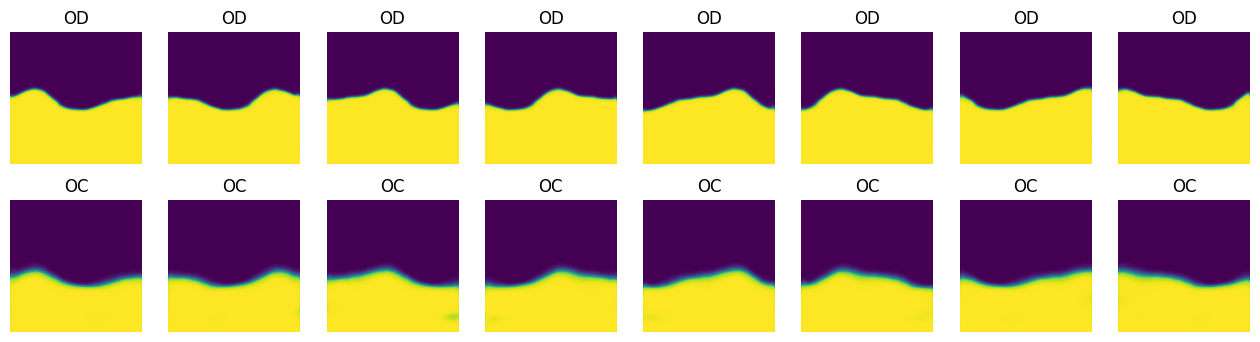

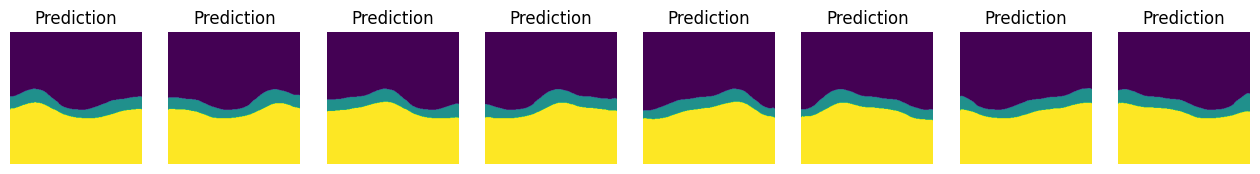

In [4]:
batch_images, batch_masks = next(iter(loader))
batch_images, batch_masks = batch_images.float(), batch_masks.long()
tta_images, tta_masks = d4_transform(batch_images, batch_masks, polar=True)

model.eval()
with torch.no_grad():
    od_logits, oc_logits = model(tta_images)
print(f'{od_logits.shape = }, {oc_logits.shape = }')
od_probabilities = torch.sigmoid(od_logits)
oc_probabilities = torch.sigmoid(oc_logits)
print(f'{od_probabilities.shape = }, {oc_probabilities.shape = }')
probabilities = torch.cat([od_probabilities, oc_probabilities], dim=1)  # (N, 2, H, W)
print(f'{probabilities.shape = }')

od_predictions = (od_probabilities > 0.5).long()  # (N, 1, H, W)
oc_predictions = (oc_probabilities > 0.5).long()  # (N, 1, H, W)
print(f'{od_predictions.shape = }, {oc_predictions.shape = }')

predictions = torch.zeros_like(oc_predictions)  # (N, 1, H, W)
predictions[od_predictions == 1] = 1
predictions[oc_predictions == 1] = 2
predictions = predictions.squeeze(1)  # (N, H, W)
print(f'{predictions.shape = }')

# Plot probabilities
_, ax = plt.subplots(2, 8, figsize=(16, 4))
ax = ax.flatten()
for i in range(8):
    ax[i].imshow(probabilities[i, 0].detach().cpu().numpy())
    ax[i].set_title('OD')
    ax[i].axis('off')
    ax[i + 8].imshow(probabilities[i, 1].detach().cpu().numpy())
    ax[i + 8].set_title('OC')
    ax[i + 8].axis('off')
plt.show()

# Plot predictions
_, ax = plt.subplots(1, 8, figsize=(16, 4))
ax = ax.flatten()
for i in range(8):
    ax[i].imshow(predictions[i].detach().cpu().numpy())
    ax[i].set_title('Prediction')
    ax[i].axis('off')
plt.show()

In [5]:
mask = masks[0]
pred = predictions[0]

met = get_metrics(mask, pred, [[1, 2], [2]])
org_dice_od = met['dice_OD']
org_dice_oc = met['dice_OC']
print('OD dice:', org_dice_od, 'OC dice:', org_dice_oc)
met

OD dice: 0.9930827255939153 OC dice: 0.984472406012162


{'accuracy_OD': 0.993255615234375,
 'precision_OD': 0.9983637507866583,
 'npv_OD': 0.9884464984002844,
 'sensitivity_OD': 0.9878572762936672,
 'specificity_OD': 0.998443952361003,
 'fpr_OD': 0.0015560476389969477,
 'fnr_OD': 0.012142723706332898,
 'dice_OD': 0.9930827255939153,
 'iou_OD': 0.9862604911408144,
 'balance_accuracy_OD': 0.9931506143273351,
 'tp_OD': 31728,
 'tn_OD': 33366,
 'fp_OD': 52,
 'fn_OD': 390,
 'accuracy_OC': 0.98760986328125,
 'precision_OC': 0.980983231707317,
 'npv_OC': 0.9920348127035831,
 'sensitivity_OC': 0.9879864895985261,
 'specificity_OC': 0.9873613292133124,
 'fpr_OC': 0.012638670786687605,
 'fnr_OC': 0.012013510401473863,
 'dice_OC': 0.984472406012162,
 'iou_OC': 0.9694196512635107,
 'balance_accuracy_OC': 0.9876739094059193,
 'tp_OC': 25741,
 'tn_OC': 38983,
 'fp_OC': 499,
 'fn_OC': 313}

joined_probabilities.shape = torch.Size([2, 2, 256, 256])
joined_predictions.shape = torch.Size([2, 256, 256])


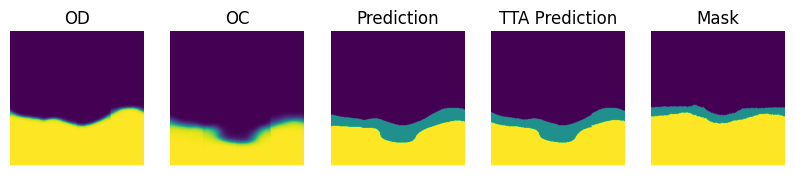

In [16]:
joined_probabilities = d4_inverse_transform(probabilities, polar=True)
print(f'{joined_probabilities.shape = }')

joined_predictions = torch.zeros_like(joined_probabilities[:, 0])
joined_predictions[joined_probabilities[:, 0] > 0.5] = 1
joined_predictions[joined_probabilities[:, 1] > 0.5] = 2
print(f'{joined_predictions.shape = }')

# Plot joined probabilities
_, ax = plt.subplots(1, 5, figsize=(10, 4))
ax = ax.flatten()
i = 0
ax[i].imshow(joined_probabilities[i, 0].detach().cpu().numpy())
ax[i].set_title('OD')
ax[i].axis('off')
ax[i + 1].imshow(joined_probabilities[i, 1].detach().cpu().numpy())
ax[i + 1].set_title('OC')
ax[i + 1].axis('off')
ax[i + 2].imshow(predictions[i].detach().cpu().numpy())
ax[i + 2].set_title('Prediction')
ax[i + 2].axis('off')
ax[i + 3].imshow(joined_predictions[i].detach().cpu().numpy())
ax[i + 3].set_title('TTA Prediction')
ax[i + 3].axis('off')
ax[i + 4].imshow(masks[0])
ax[i + 4].set_title('Mask')
ax[i + 4].axis('off')
plt.show()

predictions.shape = (16, 256, 256), joined_predictions.shape = (2, 256, 256), masks.shape = (16, 256, 256)


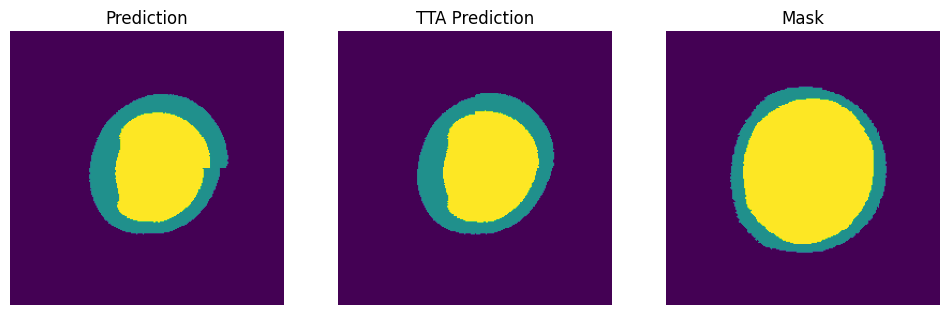

In [17]:
predictions = polar_to_cartesian(predictions)
joined_predictions = polar_to_cartesian(joined_predictions)
masks = polar_to_cartesian(masks)
print(f'{predictions.shape = }, {joined_predictions.shape = }, {masks.shape = }')

norm_pred = predictions[0]
tta_pred = joined_predictions[0]
mask = masks[0]

_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()
ax[0].imshow(norm_pred)
ax[0].set_title('Prediction')
ax[0].axis('off')
ax[1].imshow(tta_pred)
ax[1].set_title('TTA Prediction')
ax[1].axis('off')
ax[2].imshow(mask)
ax[2].set_title('Mask')
ax[2].axis('off')
plt.show()

In [18]:
mask = masks[0]
pred = joined_predictions[0]

met = get_metrics(mask, pred, [[1, 2], [2]])
new_dice_od = met['dice_OD']
new_dice_oc = met['dice_OC']
print('OD dice:', new_dice_od, 'OC dice:', new_dice_oc)
met

OD dice: 0.8442288541231648 OC dice: 0.7175105587649886


{'accuracy_OD': 0.9260101318359375,
 'precision_OD': 1.0,
 'npv_OD': 0.9074547675395068,
 'sensitivity_OD': 0.730446383901273,
 'specificity_OD': 1.0,
 'fpr_OD': 0.0,
 'fnr_OD': 0.269553616098727,
 'dice_OD': 0.8442288541231648,
 'iou_OD': 0.730446383901273,
 'balance_accuracy_OD': 0.8652231919506366,
 'tp_OD': 13140,
 'tn_OD': 47547,
 'fp_OD': 0,
 'fn_OD': 4849,
 'accuracy_OC': 0.9112091064453125,
 'precision_OC': 1.0,
 'npv_OC': 0.8999243284146803,
 'sensitivity_OC': 0.5594670300552653,
 'specificity_OC': 1.0,
 'fpr_OC': 0.0,
 'fnr_OC': 0.4405329699447347,
 'dice_OC': 0.7175105587649886,
 'iou_OC': 0.5594670300552653,
 'balance_accuracy_OC': 0.7797335150276327,
 'tp_OC': 7390,
 'tn_OC': 52327,
 'fp_OC': 0,
 'fn_OC': 5819}

In [19]:
# Difference in dice
print('OD dice difference increase:', new_dice_od - org_dice_od)
print('OC dice difference increase:', new_dice_oc - org_dice_oc)

OD dice difference increase: -0.07350625173601788
OC dice difference increase: -0.12382021538728272


In [ ]:
results = evaluate(
    'dual', model, loader,
    tta=False,
    post_process_fn=None,
    inverse_transform=undo_polar_transform,
)

In [ ]:
pp_results = evaluate(
    'dual', model, loader,
    tta=False,
    post_process_fn=postprocess,
    inverse_transform=undo_polar_transform,
)

In [ ]:
tta_results = evaluate(
    'dual', model, loader,
    tta=True,
    post_process_fn=None,
    inverse_transform=undo_polar_transform,
)

In [ ]:
tta_pp_results = evaluate(
    'dual', model, loader,
    tta=True,
    post_process_fn=postprocess,
    inverse_transform=undo_polar_transform,
)

images.shape = torch.Size([2, 3, 256, 256]), masks.shape = torch.Size([2, 256, 256])
preds.shape = torch.Size([2, 256, 256])
dilated_preds.shape = torch.Size([2, 256, 256]), eroded_preds.shape = torch.Size([2, 256, 256]), opened_preds.shape = torch.Size([2, 256, 256]), closed_preds.shape = torch.Size([2, 256, 256])


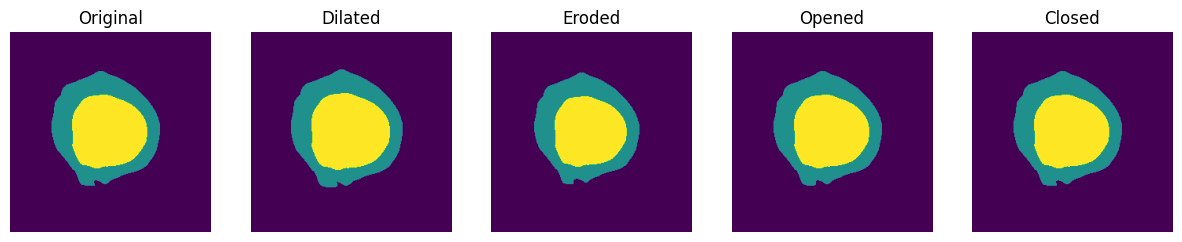

In [4]:
images, masks = next(iter(loader))
print(f'{images.shape = }, {masks.shape = }')
preds, *_ = predict('dual', model, images, masks)
print(f'{preds.shape = }')

# Apply morphological operations to the model predictions
dilated_preds = apply_morphological_operation(preds, 'dilate')
eroded_preds = apply_morphological_operation(preds, 'erode')
opened_preds = apply_morphological_operation(preds, 'open')
closed_preds = apply_morphological_operation(preds, 'close')
print(f'{dilated_preds.shape = }, {eroded_preds.shape = }, {opened_preds.shape = }, {closed_preds.shape = }')

# Plot the original and processed predictions
_, ax = plt.subplots(1, 5, figsize=(15, 5))
ax = ax.flatten()
ax[0].imshow(preds[0].detach().cpu().numpy())
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(dilated_preds[0].detach().cpu().numpy())
ax[1].set_title('Dilated')
ax[1].axis('off')
ax[2].imshow(eroded_preds[0].detach().cpu().numpy())
ax[2].set_title('Eroded')
ax[2].axis('off')
ax[3].imshow(opened_preds[0].detach().cpu().numpy())
ax[3].set_title('Opened')
ax[3].axis('off')
ax[4].imshow(closed_preds[0].detach().cpu().numpy())
ax[4].set_title('Closed')
ax[4].axis('off')
plt.show()

In [5]:
evaluate('dual', model, loader, operation='dilate', kernel_size=15)

Evaluating dual segmentation: 100%|██████████| 26/26 [01:07<00:00,  2.59s/it, accuracy_OC=0.959, accuracy_OD=0.956, balance_accuracy_OC=0.965, balance_accuracy_OD=0.969, dice_OC=0.862, dice_OD=0.919, fn_OC=638, fn_OD=300, fnr_OC=0.0289, fnr_OD=0.00717, fp_OC=4.7e+3, fp_OD=5.29e+3, fpr_OC=0.0415, fpr_OD=0.0552, iou_OC=0.765, iou_OD=0.851, npv_OC=0.994, npv_OD=0.997, precision_OC=0.788, precision_OD=0.857, sensitivity_OC=0.971, sensitivity_OD=0.993, specificity_OC=0.958, specificity_OD=0.945, tn_OC=1.06e+5, tn_OD=9.02e+4, tp_OC=1.75e+4, tp_OD=3.27e+4] 


{'accuracy_OD': 0.9564995398888221,
 'precision_OD': 0.8566350571977596,
 'npv_OD': 0.9965230323422818,
 'sensitivity_OD': 0.992831952274828,
 'specificity_OD': 0.9447714102936775,
 'fpr_OD': 0.0552285897063226,
 'fnr_OD': 0.00716804772517201,
 'dice_OD': 0.9185262230541459,
 'iou_OD': 0.8505197362708389,
 'balance_accuracy_OD': 0.9688016812842526,
 'tp_OD': 32728.96153846154,
 'tn_OD': 90236.11538461539,
 'fp_OD': 5286.346153846154,
 'fn_OD': 299.96153846153845,
 'accuracy_OC': 0.9590794489933894,
 'precision_OC': 0.7876268254842864,
 'npv_OC': 0.9939155124214434,
 'sensitivity_OC': 0.9710888831442516,
 'specificity_OC': 0.9584789018779264,
 'fpr_OC': 0.041521098122073614,
 'fnr_OC': 0.02891111685574827,
 'dice_OC': 0.8624058180777039,
 'iou_OC': 0.7654024947684885,
 'balance_accuracy_OC': 0.9647838925110891,
 'tp_OC': 17534.69230769231,
 'tn_OC': 105679.23076923077,
 'fp_OC': 4699.653846153846,
 'fn_OC': 637.8076923076923}

In [6]:
evaluate('dual', model, loader, operation='erode', kernel_size=15)

Evaluating dual segmentation: 100%|██████████| 26/26 [01:07<00:00,  2.60s/it, accuracy_OC=0.951, accuracy_OD=0.939, balance_accuracy_OC=0.844, balance_accuracy_OD=0.883, dice_OC=0.798, dice_OD=0.866, fn_OC=5.8e+3, fn_OD=7.84e+3, fnr_OC=0.308, fnr_OD=0.233, fp_OC=458, fp_OD=64.5, fpr_OC=0.00393, fpr_OD=0.000621, iou_OC=0.668, iou_OD=0.765, npv_OC=0.949, npv_OD=0.924, precision_OC=0.961, precision_OD=0.997, sensitivity_OC=0.692, sensitivity_OD=0.767, specificity_OC=0.996, specificity_OD=0.999, tn_OC=1.1e+5, tn_OD=9.55e+4, tp_OC=1.24e+4, tp_OD=25189.0]  


{'accuracy_OD': 0.9392304053673377,
 'precision_OD': 0.996653418415348,
 'npv_OD': 0.9243501151960439,
 'sensitivity_OD': 0.767048617016163,
 'specificity_OD': 0.9993788015459502,
 'fpr_OD': 0.0006211984540499346,
 'fnr_OD': 0.23295138298383694,
 'dice_OD': 0.8659022211491549,
 'iou_OD': 0.7649058491650025,
 'balance_accuracy_OD': 0.8832137092810567,
 'tp_OD': 25189.0,
 'tn_OD': 95457.96153846153,
 'fp_OD': 64.5,
 'fn_OD': 7839.923076923077,
 'accuracy_OC': 0.9513555673452524,
 'precision_OC': 0.9608690356417069,
 'npv_OC': 0.9494866521728103,
 'sensitivity_OC': 0.6919013710355603,
 'specificity_OC': 0.9960725960038705,
 'fpr_OC': 0.003927403996129518,
 'fnr_OC': 0.30809862896443985,
 'dice_OC': 0.798227663196128,
 'iou_OC': 0.6684423176565512,
 'balance_accuracy_OC': 0.8439869835197154,
 'tp_OC': 12367.538461538461,
 'tn_OC': 109921.19230769231,
 'fp_OC': 457.6923076923077,
 'fn_OC': 5804.961538461538}

In [7]:
evaluate('dual', model, loader, operation='open', kernel_size=15)

Evaluating dual segmentation: 100%|██████████| 26/26 [01:03<00:00,  2.45s/it, accuracy_OC=0.966, accuracy_OD=0.977, balance_accuracy_OC=0.924, balance_accuracy_OD=0.964, dice_OC=0.871, dice_OD=0.955, fn_OC=2.68e+3, fn_OD=2.33e+3, fnr_OC=0.136, fnr_OD=0.0662, fp_OC=1.7e+3, fp_OD=619, fpr_OC=0.0156, fpr_OD=0.00621, iou_OC=0.775, iou_OD=0.915, npv_OC=0.976, npv_OD=0.975, precision_OC=0.893, precision_OD=0.979, sensitivity_OC=0.864, sensitivity_OD=0.934, specificity_OC=0.984, specificity_OD=0.994, tn_OC=1.09e+5, tn_OD=9.49e+4, tp_OC=1.55e+4, tp_OD=3.07e+4] 


{'accuracy_OD': 0.9770974379319411,
 'precision_OD': 0.9794702291534503,
 'npv_OD': 0.9754527518582574,
 'sensitivity_OD': 0.9338231639128229,
 'specificity_OD': 0.9937861548381661,
 'fpr_OD': 0.00621384516183387,
 'fnr_OD': 0.06617683608717705,
 'dice_OD': 0.9551494476394135,
 'iou_OD': 0.9150311448424019,
 'balance_accuracy_OD': 0.9638046593754944,
 'tp_OD': 30700.30769230769,
 'tn_OD': 94903.30769230769,
 'fp_OD': 619.1538461538462,
 'fn_OD': 2328.6153846153848,
 'accuracy_OC': 0.9658804673414964,
 'precision_OC': 0.8929050670860424,
 'npv_OC': 0.9761093515118616,
 'sensitivity_OC': 0.8642490242422005,
 'specificity_OC': 0.9844387478519935,
 'fpr_OC': 0.015561252148006549,
 'fnr_OC': 0.13575097575779937,
 'dice_OC': 0.8714899929282307,
 'iou_OC': 0.775230811343832,
 'balance_accuracy_OC': 0.9243438860470969,
 'tp_OC': 15491.115384615385,
 'tn_OC': 108674.84615384616,
 'fp_OC': 1704.0384615384614,
 'fn_OC': 2681.3846153846152}

In [8]:
evaluate('dual', model, loader, operation='close', kernel_size=15)

Evaluating dual segmentation: 100%|██████████| 26/26 [01:19<00:00,  3.06s/it, accuracy_OC=0.966, accuracy_OD=0.978, balance_accuracy_OC=0.928, balance_accuracy_OD=0.965, dice_OC=0.875, dice_OD=0.956, fn_OC=2.66e+3, fn_OD=2.29e+3, fnr_OC=0.13, fnr_OD=0.0635, fp_OC=1.69e+3, fp_OD=619, fpr_OC=0.0147, fpr_OD=0.0064, iou_OC=0.781, iou_OD=0.917, npv_OC=0.976, npv_OD=0.976, precision_OC=0.895, precision_OD=0.979, sensitivity_OC=0.87, sensitivity_OD=0.937, specificity_OC=0.985, specificity_OD=0.994, tn_OC=1.09e+5, tn_OD=9.49e+4, tp_OC=1.55e+4, tp_OD=3.07e+4]   


{'accuracy_OD': 0.977512946495643,
 'precision_OD': 0.9789570474709305,
 'npv_OD': 0.9755576382875517,
 'sensitivity_OD': 0.9365139282171359,
 'specificity_OD': 0.9936033375668109,
 'fpr_OD': 0.0063966624331892145,
 'fnr_OD': 0.06348607178286414,
 'dice_OD': 0.9564183179233006,
 'iou_OD': 0.9172127216456011,
 'balance_accuracy_OD': 0.9650586328919732,
 'tp_OD': 30735.80769230769,
 'tn_OD': 94903.84615384616,
 'fp_OD': 618.6153846153846,
 'fn_OD': 2293.1153846153848,
 'accuracy_OC': 0.9663461538461539,
 'precision_OC': 0.8948372575808652,
 'npv_OC': 0.9756223309588612,
 'sensitivity_OC': 0.8704659074050484,
 'specificity_OC': 0.9853061977344104,
 'fpr_OC': 0.014693802265589695,
 'fnr_OC': 0.12953409259495166,
 'dice_OC': 0.8751944935109297,
 'iou_OC': 0.7813458955859363,
 'balance_accuracy_OC': 0.9278860525697292,
 'tp_OC': 15507.923076923076,
 'tn_OC': 108686.11538461539,
 'fp_OC': 1692.7692307692307,
 'fn_OC': 2664.576923076923}

In [46]:
images, masks = next(iter(loader))
preds, *_ = predict('dual', model, images, masks)
print(f'{preds.shape = }')

preds.shape = torch.Size([2, 256, 256])


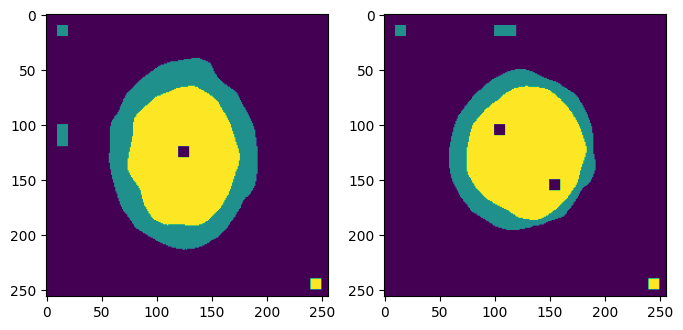

In [47]:
# Add holes to the masks
preds[0, 120:130, 120:130] = 0
preds[1, 100:110, 100:110] = 0
preds[1, 150:160, 150:160] = 0

# Add small objects to the masks
preds[0, 10:20, 10:20] = 1
preds[0, 100:120, 10:20] = 1
preds[1, 10:20, 10:20] = 1
preds[1, 10:20, 100:120] = 1
preds[0, 240:250, 240:250] = 2
preds[1, 240:250, 240:250] = 2

_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.flatten()
ax[0].imshow(preds[0].detach().cpu().numpy())
ax[1].imshow(preds[1].detach().cpu().numpy())
plt.show()


post_preds.shape = torch.Size([2, 256, 256])


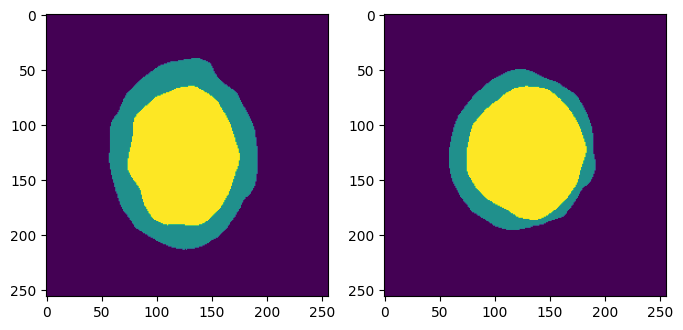

In [53]:
post_preds = postprocess(preds)
print(f'{post_preds.shape = }')

_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.flatten()
ax[0].imshow(post_preds[0].detach().cpu().numpy())
ax[1].imshow(post_preds[1].detach().cpu().numpy())
plt.show()

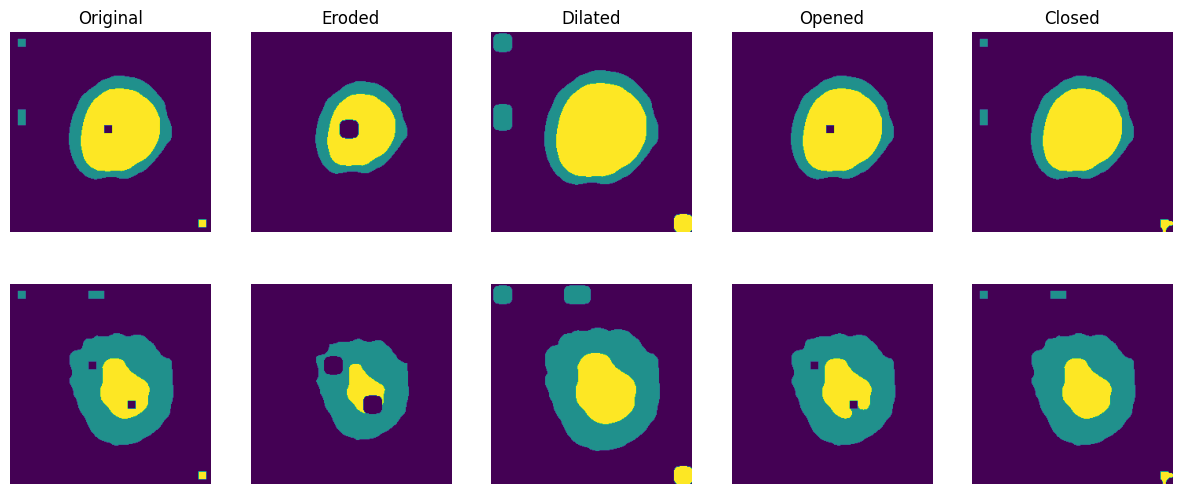

In [24]:
preds_np = tensor_to_numpy(preds)

eroded = erosion(preds_np, 15)
dilated = dilation(preds_np, 15)
opened = opening(preds_np, 15)
closed = closing(preds_np, 15)

_, ax = plt.subplots(2, 5, figsize=(15, 6))
ax = ax.flatten()
ax[0].imshow(preds_np[0])
ax[5].imshow(preds_np[1])
ax[0].set_title('Original')
ax[1].imshow(eroded[0])
ax[6].imshow(eroded[1])
ax[1].set_title('Eroded')
ax[2].imshow(dilated[0])
ax[7].imshow(dilated[1])
ax[2].set_title('Dilated')
ax[3].imshow(opened[0])
ax[8].imshow(opened[1])
ax[3].set_title('Opened')
ax[4].imshow(closed[0])
ax[9].imshow(closed[1])
ax[4].set_title('Closed')
for a in ax:
    a.axis('off')
plt.show()


discs.shape = (2, 256, 256), cups.shape = (2, 256, 256)


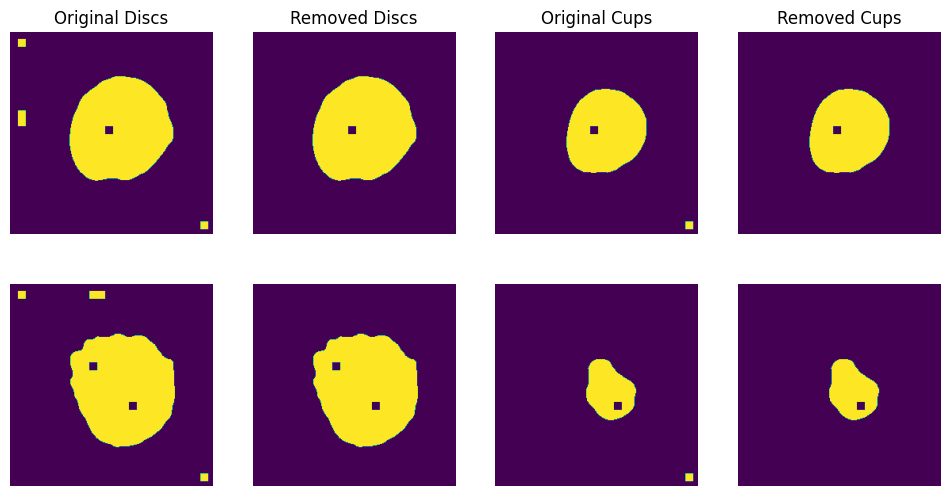

In [25]:
discs, cups = separate_disc_and_cup(preds)
print(f'{discs.shape = }, {cups.shape = }')

removed_discs = remove_small_components(discs, 0.05)
removed_cups = remove_small_components(cups, 0.03)

_, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()
ax[0].imshow(discs[0])
ax[4].imshow(discs[1])
ax[0].set_title('Original Discs')
ax[1].imshow(removed_discs[0])
ax[5].imshow(removed_discs[1])
ax[1].set_title('Removed Discs')
ax[2].imshow(cups[0])
ax[6].imshow(cups[1])
ax[2].set_title('Original Cups')
ax[3].imshow(removed_cups[0])
ax[7].imshow(removed_cups[1])
ax[3].set_title('Removed Cups')
for a in ax:
    a.axis('off')
plt.show()


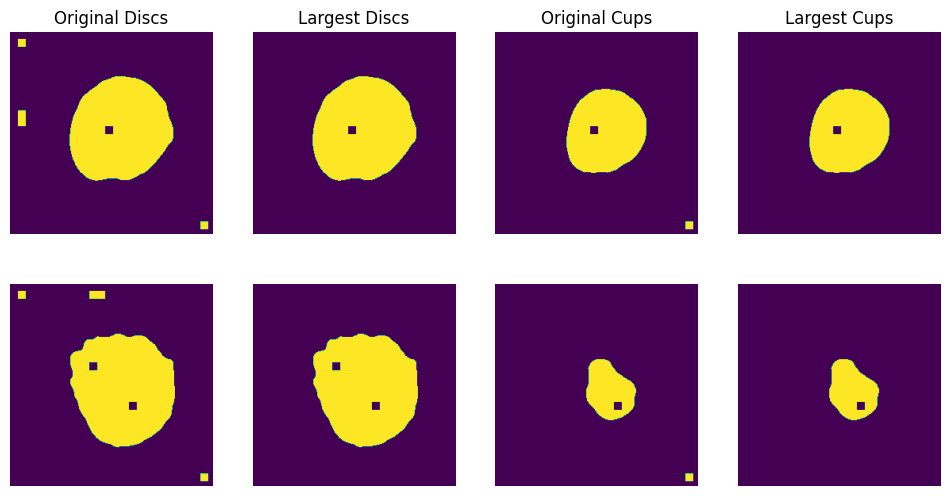

In [26]:
largest_discs = keep_largest_component(discs)
largest_cups = keep_largest_component(cups)

_, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()
ax[0].imshow(discs[0])
ax[4].imshow(discs[1])
ax[0].set_title('Original Discs')
ax[1].imshow(largest_discs[0])
ax[5].imshow(largest_discs[1])
ax[1].set_title('Largest Discs')
ax[2].imshow(cups[0])
ax[6].imshow(cups[1])
ax[2].set_title('Original Cups')
ax[3].imshow(largest_cups[0])
ax[7].imshow(largest_cups[1])
ax[3].set_title('Largest Cups')
for a in ax:
    a.axis('off')
plt.show()

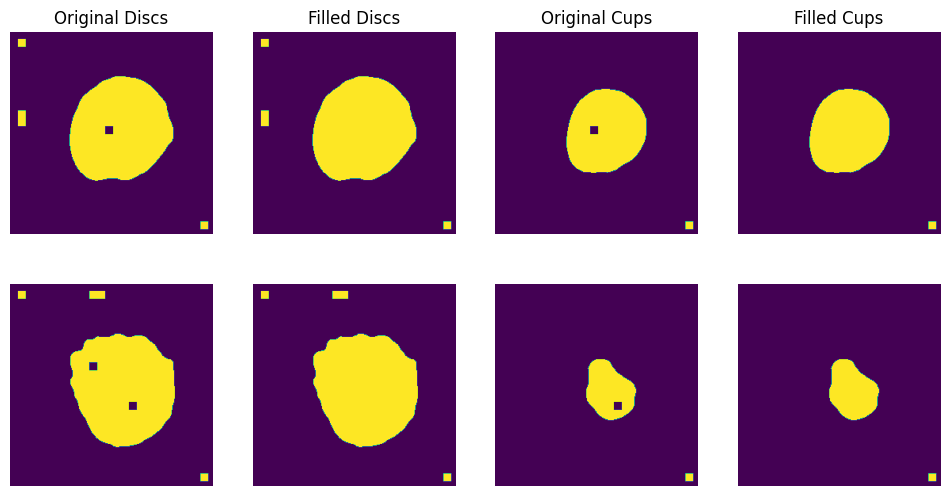

In [27]:
filled_discs = fill_holes(discs)
filled_cups = fill_holes(cups)

_, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()
ax[0].imshow(discs[0])
ax[4].imshow(discs[1])
ax[0].set_title('Original Discs')
ax[1].imshow(filled_discs[0])
ax[5].imshow(filled_discs[1])
ax[1].set_title('Filled Discs')
ax[2].imshow(cups[0])
ax[6].imshow(cups[1])
ax[2].set_title('Original Cups')
ax[3].imshow(filled_cups[0])
ax[7].imshow(filled_cups[1])
ax[3].set_title('Filled Cups')
for a in ax:
    a.axis('off')
plt.show()

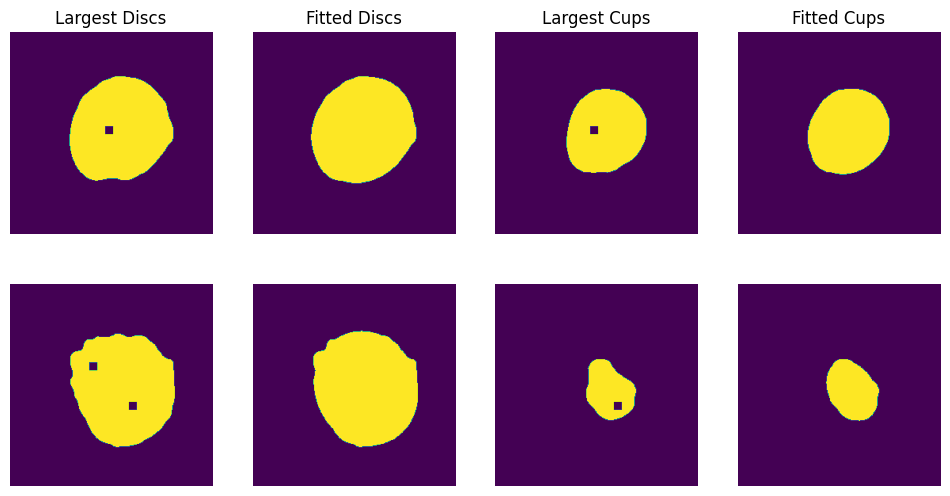

In [28]:
fitted_discs = fit_ellipse(largest_discs)
fitted_cups = fit_ellipse(largest_cups)

_, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()
ax[0].imshow(largest_discs[0])
ax[4].imshow(largest_discs[1])
ax[0].set_title('Largest Discs')
ax[1].imshow(fitted_discs[0])
ax[5].imshow(fitted_discs[1])
ax[1].set_title('Fitted Discs')
ax[2].imshow(largest_cups[0])
ax[6].imshow(largest_cups[1])
ax[2].set_title('Largest Cups')
ax[3].imshow(fitted_cups[0])
ax[7].imshow(fitted_cups[1])
ax[3].set_title('Fitted Cups')
for a in ax:
    a.axis('off')
plt.show()


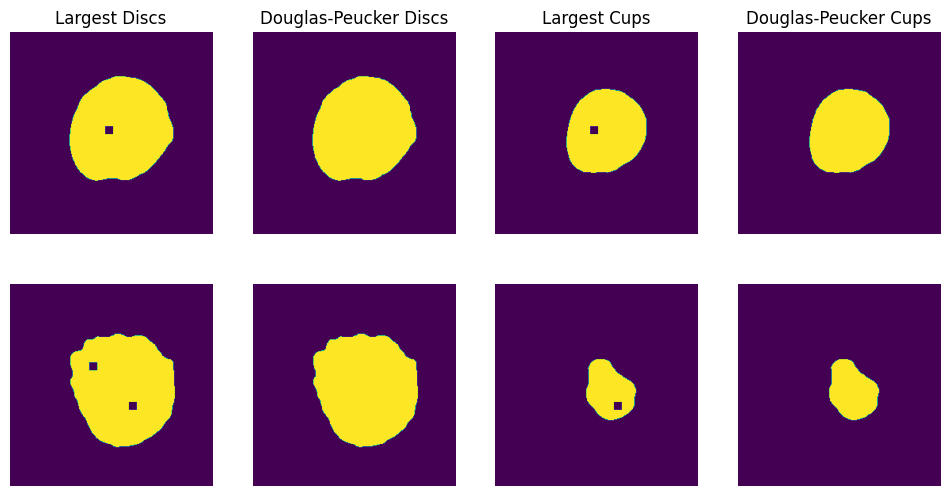

In [32]:
# Douglas Peucker algorithm
dp_discs = douglas_peucker(largest_discs, 0.5)
dp_cups = douglas_peucker(largest_cups, 0.5)

_, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()
ax[0].imshow(largest_discs[0])
ax[4].imshow(largest_discs[1])
ax[0].set_title('Largest Discs')
ax[1].imshow(dp_discs[0])
ax[5].imshow(dp_discs[1])
ax[1].set_title('Douglas-Peucker Discs')
ax[2].imshow(largest_cups[0])
ax[6].imshow(largest_cups[1])
ax[2].set_title('Largest Cups')
ax[3].imshow(dp_cups[0])
ax[7].imshow(dp_cups[1])
ax[3].set_title('Douglas-Peucker Cups')
for a in ax:
    a.axis('off')
plt.show()

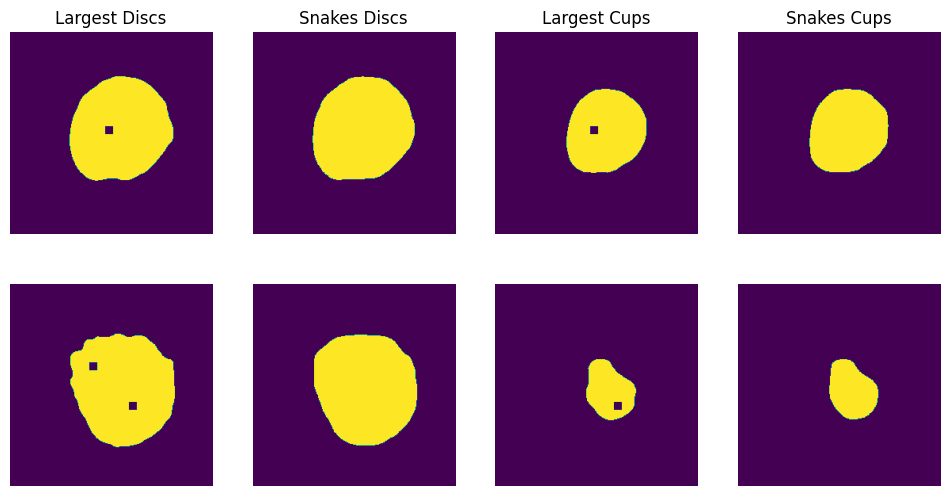

In [33]:
# Smooth
snakes_discs = snakes(largest_discs)
snakes_cups = snakes(largest_cups)

_, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flatten()
ax[0].imshow(largest_discs[0])
ax[4].imshow(largest_discs[1])
ax[0].set_title('Largest Discs')
ax[1].imshow(snakes_discs[0])
ax[5].imshow(snakes_discs[1])
ax[1].set_title('Snakes Discs')
ax[2].imshow(largest_cups[0])
ax[6].imshow(largest_cups[1])
ax[2].set_title('Largest Cups')
ax[3].imshow(snakes_cups[0])
ax[7].imshow(snakes_cups[1])
ax[3].set_title('Snakes Cups')
for a in ax:
    a.axis('off')
plt.show()

In [54]:
evaluate('dual', model, loader)

Evaluating dual segmentation: 100%|██████████| 26/26 [01:36<00:00,  3.72s/it, accuracy_OC=0.966, accuracy_OD=0.977, balance_accuracy_OC=0.925, balance_accuracy_OD=0.965, dice_OC=0.873, dice_OD=0.956, fn_OC=2.66e+3, fn_OD=2.32e+3, fnr_OC=0.135, fnr_OD=0.063, fp_OC=1.71e+3, fp_OD=624, fpr_OC=0.0149, fpr_OD=0.00637, iou_OC=0.777, iou_OD=0.917, npv_OC=0.976, npv_OD=0.976, precision_OC=0.896, precision_OD=0.978, sensitivity_OC=0.865, sensitivity_OD=0.937, specificity_OC=0.985, specificity_OD=0.994, tn_OC=1.09e+5, tn_OD=9.49e+4, tp_OC=1.55e+4, tp_OD=3.07e+4] 


{'accuracy_OD': 0.9774043743426983,
 'precision_OD': 0.9778309048477636,
 'npv_OD': 0.9757025305470333,
 'sensitivity_OD': 0.9369815957701001,
 'specificity_OD': 0.9936312980697306,
 'fpr_OD': 0.006368701930269297,
 'fnr_OD': 0.06301840422989999,
 'dice_OD': 0.9560040184791107,
 'iou_OD': 0.9168694913669311,
 'balance_accuracy_OD': 0.9653064469199154,
 'tp_OD': 30713.884615384617,
 'tn_OD': 94898.42307692308,
 'fp_OD': 624.0384615384615,
 'fn_OD': 2315.0384615384614,
 'accuracy_OC': 0.9661419208233173,
 'precision_OC': 0.8956726426426991,
 'npv_OC': 0.9757256921427145,
 'sensitivity_OC': 0.8651484526078707,
 'specificity_OC': 0.9850878319810327,
 'fpr_OC': 0.014912168018967335,
 'fnr_OC': 0.1348515473921293,
 'dice_OC': 0.8729043818516425,
 'iou_OC': 0.7768805925769626,
 'balance_accuracy_OC': 0.9251181422944517,
 'tp_OC': 15508.923076923076,
 'tn_OC': 108664.23076923077,
 'fp_OC': 1714.6538461538462,
 'fn_OC': 2663.576923076923}

In [61]:
evaluate('dual', model, loader, post_process_fn=postprocess)

Evaluating dual segmentation: 100%|██████████| 26/26 [01:17<00:00,  2.98s/it, accuracy_OC=0.966, accuracy_OD=0.977, balance_accuracy_OC=0.924, balance_accuracy_OD=0.964, dice_OC=0.871, dice_OD=0.956, fn_OC=2.68e+3, fn_OD=2.32e+3, fnr_OC=0.138, fnr_OD=0.066, fp_OC=1.7e+3, fp_OD=618, fpr_OC=0.0147, fpr_OD=0.00623, iou_OC=0.773, iou_OD=0.916, npv_OC=0.975, npv_OD=0.975, precision_OC=0.897, precision_OD=0.98, sensitivity_OC=0.862, sensitivity_OD=0.934, specificity_OC=0.985, specificity_OD=0.994, tn_OC=1.09e+5, tn_OD=9.49e+4, tp_OC=1.55e+4, tp_OD=3.07e+4]   


{'accuracy_OD': 0.9772230295034555,
 'precision_OD': 0.9798828210182285,
 'npv_OD': 0.9752553106803229,
 'sensitivity_OD': 0.9340312201376957,
 'specificity_OD': 0.9937739863943139,
 'fpr_OD': 0.006226013605686041,
 'fnr_OD': 0.06596877986230422,
 'dice_OD': 0.9557105172665392,
 'iou_OD': 0.9157812408797281,
 'balance_accuracy_OD': 0.963902603266005,
 'tp_OD': 30707.346153846152,
 'tn_OD': 94904.03846153847,
 'fp_OD': 618.4230769230769,
 'fn_OD': 2321.576923076923,
 'accuracy_OC': 0.9658414400540866,
 'precision_OC': 0.8970984616481066,
 'npv_OC': 0.9752646370851052,
 'sensitivity_OC': 0.8619562608426132,
 'specificity_OC': 0.985271394871318,
 'fpr_OC': 0.014728605128682154,
 'fnr_OC': 0.13804373915738674,
 'dice_OC': 0.8708819517542679,
 'iou_OC': 0.7730104977430403,
 'balance_accuracy_OC': 0.9236138278569656,
 'tp_OC': 15491.384615384615,
 'tn_OC': 108680.73076923077,
 'fp_OC': 1698.1538461538462,
 'fn_OC': 2681.1153846153848}

images.shape = torch.Size([2, 3, 256, 256]), masks.shape = torch.Size([2, 256, 256]), images.dtype = torch.float32, masks.dtype = torch.uint8
preds.shape = torch.Size([2, 256, 256]), probs.shape = torch.Size([2, 2, 256, 256])
dense_preds.shape = (2, 256, 256)


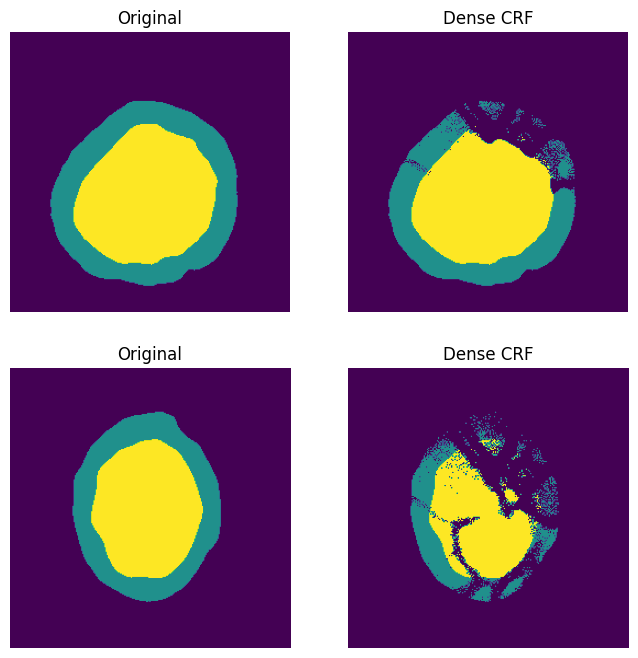

In [5]:
# Dense CRF
images, masks = next(iter(loader))

preds, probs, _ = predict('dual', model, images, masks)
print(f'{images.shape = }, {masks.shape = }, {images.dtype = }, {masks.dtype = }')
print(f'{preds.shape = }, {probs.shape = }')

# Apply dense CRF
dense_preds = dense_crf(preds, images)
print(f'{dense_preds.shape = }')

# Plot the original and processed predictions
_, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
ax[0].imshow(preds[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(dense_preds[0])
ax[1].set_title('Dense CRF')
ax[1].axis('off')
ax[2].imshow(preds[1])
ax[2].set_title('Original')
ax[2].axis('off')
ax[3].imshow(dense_preds[1])
ax[3].set_title('Dense CRF')
ax[3].axis('off')
plt.show()